In [27]:
MY_API_TOKEN = 'c52b7825851b4357af3e06c1888152f0'

In [28]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from scipy.cluster.vq import whiten, kmeans2
%matplotlib inline

In [29]:
def call_football_api(uri, result_key):
    result = requests.get(uri, headers = { 'X-Auth-Token': MY_API_TOKEN, 'X-Response-Control': 'full' })
    if result.status_code == 200:
        return result.json()[result_key]
    else:
        print('API is not reachable')
        return None

In [32]:
teams = call_football_api('http://api.football-data.org/v1/soccerseasons/440/teams', 'teams')
# teams

In [33]:
teams_data = list()
for team in teams:
    name = team['name']
    tid = team['_links']['self']['href'].split('/')[-1]
    value = int(team['squadMarketValue'].replace(',','').replace(' €','')) if team['squadMarketValue'] is not None else 0
    wins = 0
    losses = 0
    goals = 0
    fixtures = call_football_api(team['_links']['fixtures']['href'], 'fixtures')
    for f in fixtures:
        # pprint(f)
        balls_home = f['result']['goalsHomeTeam'] if f['result']['goalsHomeTeam'] else 0
        balls_away = f['result']['goalsAwayTeam'] if f['result']['goalsAwayTeam'] else 0
        
        if balls_home or balls_away:  # there are non zerovalid values
            if name == f['homeTeamName']:
                goals += balls_home
                if balls_home > balls_away:
                    wins += 1
                elif balls_home < balls_away:
                    losses +=1
            else:
                goals += balls_away
                if balls_home < balls_away:
                    wins += 1
                elif balls_home > balls_away:
                    losses +=1
    teams_data.append({'tid':tid, 'name': name, 'value': value, 'wins': wins, 'losses': losses, 'goals': goals})

In [34]:
print(len(teams_data))
data = pd.DataFrame(teams_data)
data = data[['name', 'value', 'wins', 'goals', 'losses']].sort_values(by='value', axis=0, ascending=False).reset_index(drop=True)
# data.head(30)

32


In [37]:
whitened = whiten(data[['value', 'wins']].as_matrix())

In [38]:
centroids, cluster_map = kmeans2(whitened, 4)
centroids, cluster_map

C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\vq.py:653: UserWarning: One of the clusters is empty. Re-run kmean with a different initialization.
  warnings.warn("One of the clusters is empty. "


(array([[ 2.29874237,  1.41960766],
        [ 1.00938695,  1.75772316],
        [ 0.17326725,  0.08143891],
        [ 2.51389003,  2.38887471]]),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [39]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]

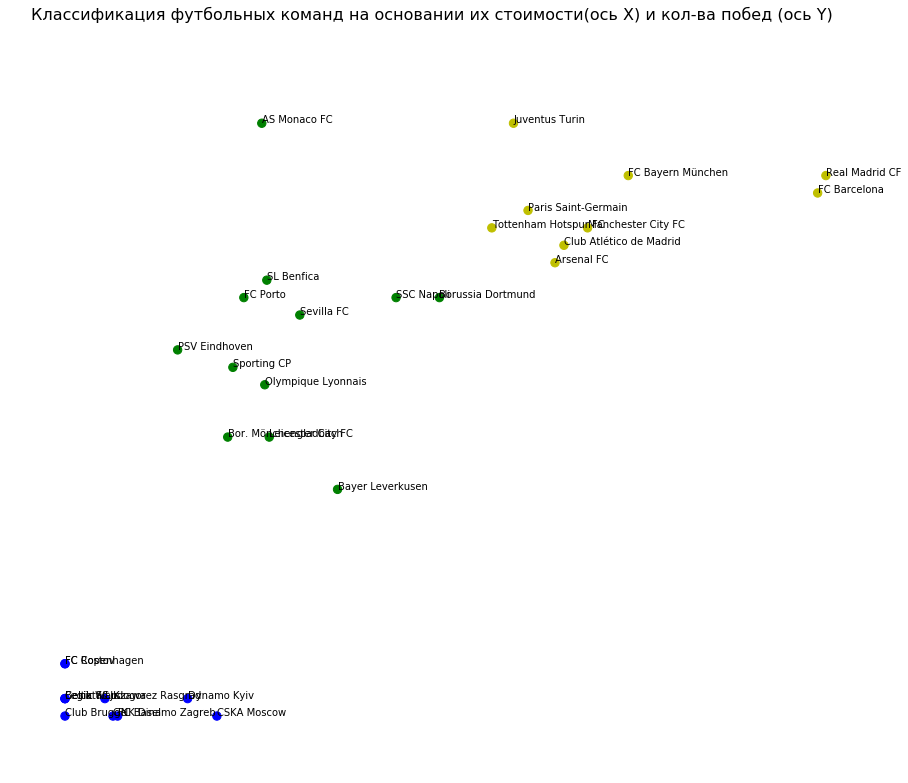

In [40]:
fig, ax = plt.subplots(figsize=(15, 12))
ax.axis('off')
fig.suptitle("Классификация футбольных команд на основании их стоимости(ось Х) и кол-ва побед (ось Y)", fontsize=16)
ax.scatter(data['value'], data['wins'], c=colors, s=70)
for i in range(len(data)):
    ax.annotate(data['name'][i], (data['value'][i], data['wins'][i]))